In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as  xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")



In [224]:
#read file
df = pd.read_csv("total_frequency_bydate.csv")
#set data as index
df = df.set_index("date")
#convert date to date type
df.index = pd.to_datetime(df.index)

In [225]:
df.head()

,Frequency
date,
2016-01-01,561
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345


<function matplotlib.pyplot.show(close=None, block=None)>

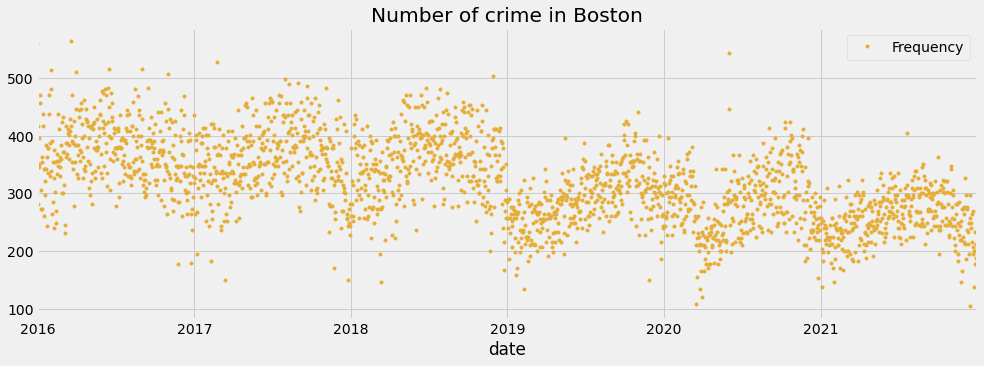

In [226]:
#visualize the data
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[2],
        title="Number of crime in Boston")
plt.show

<AxesSubplot:ylabel='Frequency'>

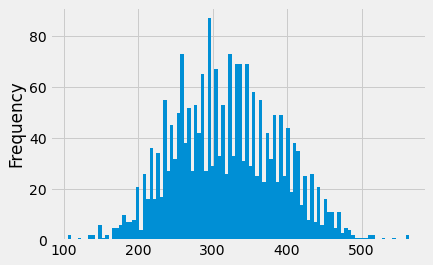

In [227]:
#outlier analysis and removal
#histogram
df['Frequency'].plot(kind="hist",bins=100)

<AxesSubplot:xlabel='date'>

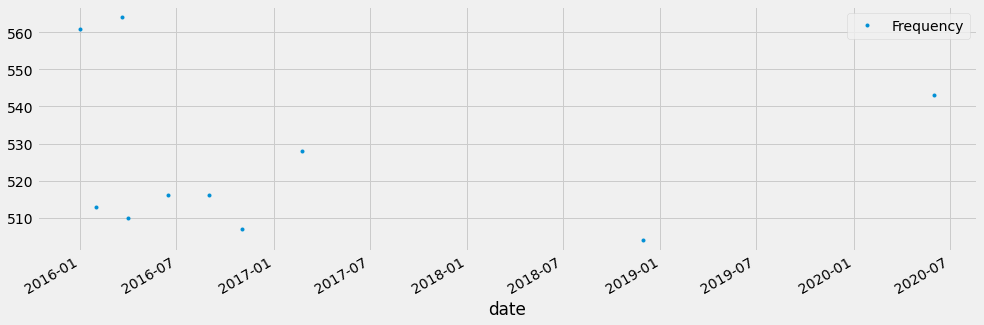

In [228]:
df.query('Frequency >500').plot(figsize=(15,5),style=".")

<AxesSubplot:xlabel='date'>

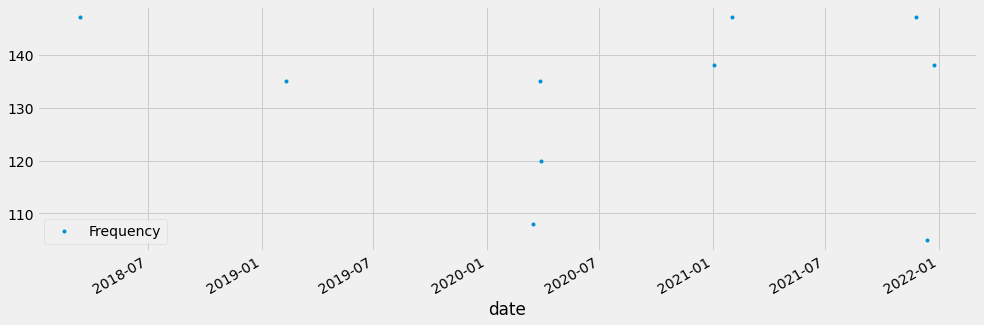

In [229]:
df.query('Frequency < 150').plot(figsize=(15,5),style=".")

In [230]:
#remove outlier
df = df.query('Frequency > 150' and 'Frequency < 500')

df

,Frequency
date,
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345
2016-01-06,396
...,...
2021-12-27,234
2021-12-28,213
2021-12-29,201


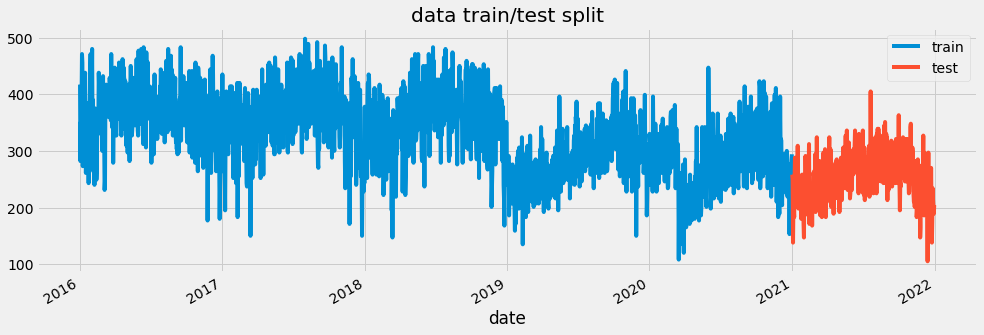

In [231]:
#train test split
train = df.loc[df.index<'01-01-2021']
test = df.loc[df.index>='01-01-2021']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="train",title='data train/test split')
test.plot(ax=ax,label='test')
ax.legend(['train','test'])
plt.show()

In [232]:
#time series cross validation
from sklearn.model_selection import TimeSeriesSplit


In [233]:
#180 days 
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

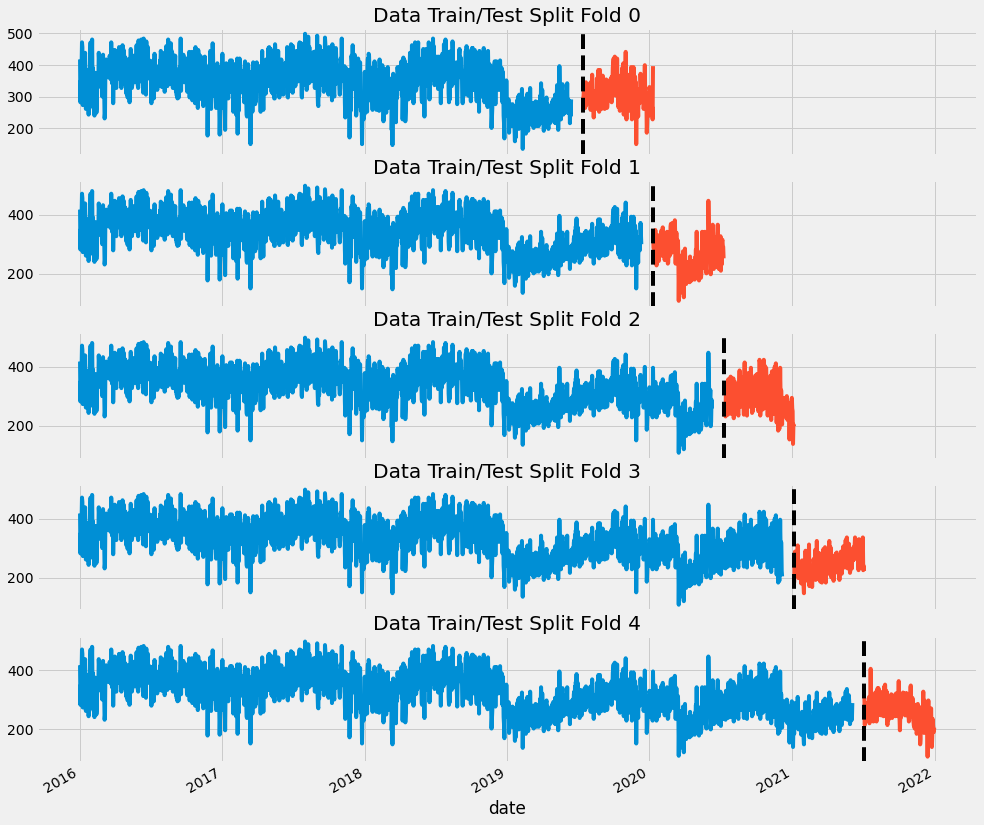

In [234]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Frequency'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Frequency'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [235]:
#forecasting
#feature creation
def create_feature(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    return df 
df = create_feature(df)



In [236]:
#lag features
target_map = df['Frequency'].to_dict()

In [237]:
def add_lags(df):
    target_map = df['Frequency'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df

In [238]:
df = add_lags(df)

In [239]:
#train use cross validation
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feature(train)
    test = create_feature(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Frequency'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gblinear',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:11:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:327.00140	validation_1-rmse:288.63278


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:85.27989	validation_1-rmse:78.52315
[200]	validation_0-rmse:79.11929	validation_1-rmse:69.85217
[300]	validation_0-rmse:75.19064	validation_1-rmse:64.30834
[400]	validation_0-rmse:72.55120	validation_1-rmse:60.74834
[500]	validation_0-rmse:70.68274	validation_1-rmse:58.44205
[600]	validation_0-rmse:69.29567	validation_1-rmse:56.94334
[700]	validation_0-rmse:68.22315	validation_1-rmse:55.99025
[800]	validation_0-rmse:67.36616	validation_1-rmse:55.40756
[900]	validation_0-rmse:66.66338	validation_1-rmse:55.07802
[999]	validation_0-rmse:66.08150	validation_1-rmse:54.92915
[12:11:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:83.18649	validation_1-rmse:64.94594
[200]	validation_0-rmse:77.34750	validation_1-rmse:65.81703
[300]	validation_0-rmse:73.52724	validation_1-rmse:67.47594
[400]	validation_0-rmse:70.93609	validation_1-rmse:69.22969
[500]	validation_0-rmse:69.10802	validation_1-rmse:70.83015
[600]	validation_0-rmse:67.76598	validation_1-rmse:72.20702
[700]	validation_0-rmse:66.74276	validation_1-rmse:73.37219
[800]	validation_0-rmse:65.93645	validation_1-rmse:74.35531
[900]	validation_0-rmse:65.28365	validation_1-rmse:75.18233
[999]	validation_0-rmse:64.74824	validation_1-rmse:75.88099
[12:11:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:82.36682	validation_1-rmse:85.32558
[200]	validation_0-rmse:77.07336	validation_1-rmse:77.93112
[300]	validation_0-rmse:73.78171	validation_1-rmse:73.15329
[400]	validation_0-rmse:71.63052	validation_1-rmse:70.02106
[500]	validation_0-rmse:70.14630	validation_1-rmse:67.96021
[600]	validation_0-rmse:69.06885	validation_1-rmse:66.58295
[700]	validation_0-rmse:68.25016	validation_1-rmse:65.66977
[800]	validation_0-rmse:67.60352	validation_1-rmse:65.07433
[900]	validation_0-rmse:67.07675	validation_1-rmse:64.69983
[999]	validation_0-rmse:66.64115	validation_1-rmse:64.48095
[12:11:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:81.26099	validation_1-rmse:44.96931
[200]	validation_0-rmse:76.18002	validation_1-rmse:47.51530
[300]	validation_0-rmse:72.95233	validation_1-rmse:50.29837
[400]	validation_0-rmse:70.82395	validation_1-rmse:52.76691
[500]	validation_0-rmse:69.35914	validation_1-rmse:54.80984
[600]	validation_0-rmse:68.30460	validation_1-rmse:56.46641
[700]	validation_0-rmse:67.51221	validation_1-rmse:57.80870
[800]	validation_0-rmse:66.89367	validation_1-rmse:58.90292
[900]	validation_0-rmse:66.39520	validation_1-rmse:59.80877
[999]	validation_0-rmse:65.98686	validation_1-rmse:60.56266
[12:11:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:80.11505	validation_1-rmse:89.40706
[200]	validation_0-rmse:75.39970	validation_1-rmse:80.34117
[300]	validation_0-rmse:72.49571	validation_1-rmse:74.32712
[400]	validation_0-rmse:70.62454	validation_1-rmse:70.37257
[500]	validation_0-rmse:69.35671	validation_1-rmse:67.80737
[600]	validation_0-rmse:68.45293	validation_1-rmse:66.19302
[700]	validation_0-rmse:67.77779	validation_1-rmse:65.20230
[800]	validation_0-rmse:67.25236	validation_1-rmse:64.63158
[900]	validation_0-rmse:66.82928	validation_1-rmse:64.34609
[999]	validation_0-rmse:66.48262	validation_1-rmse:64.24960


In [240]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 64.0207
Fold scores:[54.92914473893939, 75.88099177470758, 64.48094719290116, 60.562661264970345, 64.24960047761373]


In [241]:
#predict the future
# Retrain on all data
df = create_feature(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Frequency'

X_all = df[FEATURES]
y_all = df['Frequency']

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=3200,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:11:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:322.00189


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:126.48710
[200]	validation_0-rmse:63.25514
[300]	validation_0-rmse:47.69875
[400]	validation_0-rmse:44.45526
[500]	validation_0-rmse:43.53143
[600]	validation_0-rmse:43.03102
[700]	validation_0-rmse:42.61124
[800]	validation_0-rmse:42.24141
[900]	validation_0-rmse:41.91871
[1000]	validation_0-rmse:41.53646
[1100]	validation_0-rmse:41.20990
[1200]	validation_0-rmse:40.90313
[1300]	validation_0-rmse:40.62991
[1400]	validation_0-rmse:40.35601
[1500]	validation_0-rmse:40.11123
[1600]	validation_0-rmse:39.88179
[1700]	validation_0-rmse:39.60895
[1800]	validation_0-rmse:39.36041
[1900]	validation_0-rmse:39.14116
[2000]	validation_0-rmse:38.93492
[2100]	validation_0-rmse:38.72815
[2200]	validation_0-rmse:38.50453
[2300]	validation_0-rmse:38.26614
[2400]	validation_0-rmse:38.04224
[2500]	validation_0-rmse:37.83996
[2600]	validation_0-rmse:37.63705
[2700]	validation_0-rmse:37.41214
[2800]	validation_0-rmse:37.24003
[2900]	validation_0-rmse:37.02923
[3000]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3200, n_jobs=10,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [242]:
#test the sample data
test_data = X_all.loc[X_all.index>= '01-01-2021']
test_data['prediction'] = reg.predict(test_data)

test_data

/var/folders/fr/0_7xr4pj1yb9zdvs7vk07dd80000gn/T/ipykernel_14649/2996367306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = reg.predict(test_data)


,dayofyear,dayofweek,quarter,month,year,lag1,lag2,lag3,prediction
date,,,,,,,,,
2021-01-01,1,4,1,1,2021,312.0,309.0,375.0,258.870911
2021-01-02,2,5,1,1,2021,321.0,249.0,264.0,236.840103
2021-01-03,3,6,1,1,2021,318.0,297.0,294.0,165.242447
2021-01-04,4,0,1,1,2021,222.0,291.0,249.0,206.683136
2021-01-05,5,1,1,1,2021,204.0,369.0,249.0,206.484436
...,...,...,...,...,...,...,...,...,...
2021-12-27,361,0,4,12,2021,273.0,228.0,282.0,219.850250
2021-12-28,362,1,4,12,2021,225.0,300.0,243.0,208.601547
2021-12-29,363,2,4,12,2021,273.0,249.0,303.0,210.140152


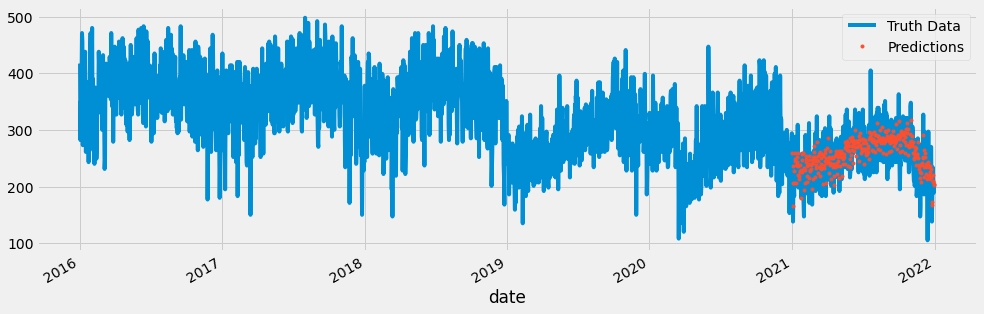

In [243]:
#plot the prediction from sample data
ax = df[['Frequency']].plot(figsize=(15, 5))
test_data['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])

In [244]:
#r2 score
from sklearn.metrics import r2_score
score_data = df.loc[df.index>= '01-01-2021']

r2_score(score_data["Frequency"],test_data["prediction"])

0.5311462044514055

In [245]:
df.index.max()


Timestamp('2021-12-31 00:00:00')

In [246]:
#create future data
future = pd.date_range('2022-01-01','2022-12-31')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [247]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,Frequency,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture
2022-01-01,NaN,2022,1,1,5,1,1,264.0,258.0,237.0,True
2022-01-02,NaN,2022,1,2,6,1,2,327.0,276.0,195.0,True
2022-01-03,NaN,2022,1,3,0,1,3,213.0,243.0,243.0,True
2022-01-04,NaN,2022,1,4,1,1,4,186.0,306.0,237.0,True
2022-01-05,NaN,2022,1,5,2,1,5,297.0,297.0,306.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,2022,12,27,1,4,361,NaN,NaN,NaN,True
2022-12-28,NaN,2022,12,28,2,4,362,NaN,NaN,NaN,True
2022-12-29,NaN,2022,12,29,3,4,363,NaN,NaN,NaN,True
2022-12-30,NaN,2022,12,30,4,4,364,NaN,NaN,NaN,True


In [248]:
#predict future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


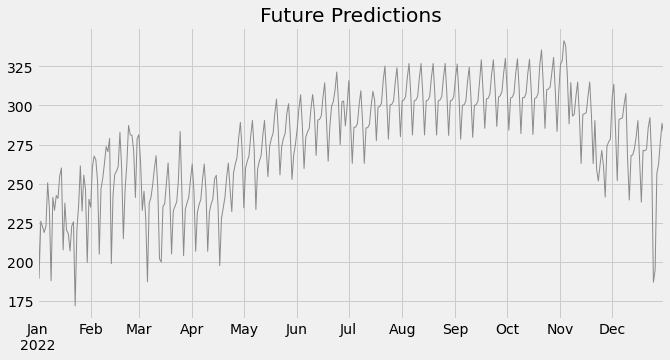

In [249]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [250]:
del future_w_features['Frequency']
future_w_features = future_w_features.rename(columns={'pred':'Frequency'})





In [251]:
future_w_features

,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture,Frequency
2022-01-01,2022,1,1,5,1,1,264.0,258.0,237.0,True,321.078003
2022-01-02,2022,1,2,6,1,2,327.0,276.0,195.0,True,189.175644
2022-01-03,2022,1,3,0,1,3,213.0,243.0,243.0,True,225.802521
2022-01-04,2022,1,4,1,1,4,186.0,306.0,237.0,True,222.392212
2022-01-05,2022,1,5,2,1,5,297.0,297.0,306.0,True,218.614380
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,2022,12,27,1,4,361,NaN,NaN,NaN,True,256.243744
2022-12-28,2022,12,28,2,4,362,NaN,NaN,NaN,True,262.505341
2022-12-29,2022,12,29,3,4,363,NaN,NaN,NaN,True,276.242310
2022-12-30,2022,12,30,4,4,364,NaN,NaN,NaN,True,288.536591


In [259]:
#merge future_w_features and df
final_data = pd.concat([df, future_w_features])
final_data = final_data['Frequency']
final_data


2016-01-02    417.000000
2016-01-03    282.000000
2016-01-04    351.000000
2016-01-05    345.000000
2016-01-06    396.000000
                 ...    
2022-12-27    256.243744
2022-12-28    262.505341
2022-12-29    276.242310
2022-12-30    288.536591
2022-12-31    281.897308
Name: Frequency, Length: 2547, dtype: float64

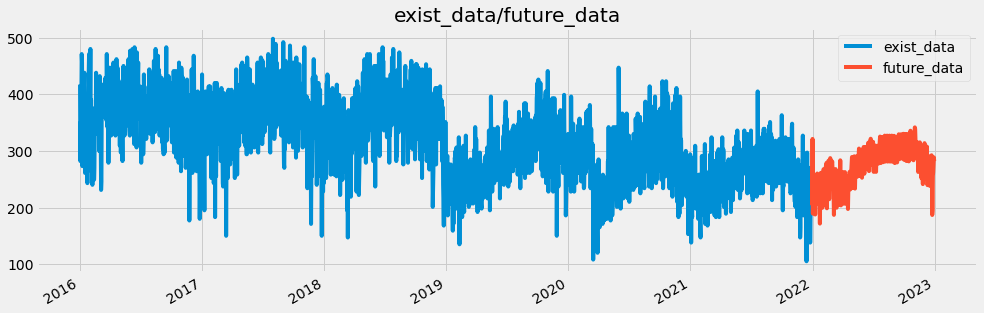

In [260]:
#plot the exist data with future data
exist_data = final_data.loc[final_data.index<'12-31-2021']
future_data = final_data.loc[final_data.index>='12-31-2021']

fig, ax = plt.subplots(figsize=(15,5))
exist_data.plot(ax=ax,label="exist_data",title='exist_data/future_data')
future_data.plot(ax=ax,label='future_data')
ax.legend(['exist_data','future_data'])
plt.show()